This is a collection of highlights and comments for Chapter 3 of PRML book. page numbers are probably based on first printing of the book. (I only have a PDF version of the book's (possibly) first printing).

## 3.1 Linear Basis Function Models

### 3.1.4 Regularized least squares

For a general discussion on how to deal with bias term when having regularization, see my special notes on linear models (`/machine_learning/misc/linear_models.ipynb`)

### 3.1.5 Multiple Outputs

#### pp. 147

> This result is unsurprising because the parameters W define only the mean of the Gaussian noise distribution, and we know from Section 2.3.4 that the maximum likelihood solution for the mean of a multivariate Gaussian is independent of the covariance.

I would say the result of ML solution for mean of multivariate Gaussian is consistent with that we can decouple different target variables. However, this intuition needs proof.

## 3.3 Bayesian Linear Regression

### 3.3.2 Predictive distribution

#### pp. 157

> Note that the predictive uncertainty depends on x and is smallest in the neighbourhood of the data points. Also note that the level of uncertainty decreases as more data points are observed.

Bayesian regression is beautiful, but intractable most of the time.

#### pp. 158

> If we used localized basis functions such as Gaussians, then in regions away from the basis function centres, the contribution from the second term in the predictive variance (3.59) will go to zero, leaving only the noise contribution $\beta^{-1}$. Thus, the model becomes very confident in its predictions when extrapolating outside the region occupied by the basis functions, which is generally an undesirable behaviour.

This is true. Check (3.59). Because for Gaussian basis functions, $\phi(\mathbf{x})$ would be very small if $\mathbf{x}$ is far away from the centers of those basis functions. But on the other hand, in the big data era, I think we should be able to get training data points at most of input space any way (well maybe not so much due to curse of dimensionality).

### 3.3.3 Equivalent kernel

#### pp. 159

> Note that this localization property holds not only for the localized Gaussian basis functions but also for the nonlocal polynomial and sigmoidal basis functions, as illustrated in Figure 3.11.

This is confusing in the first sight. But notice that, actually, even for a scalar input, the feature vector is a vector, so even sigmoid basis function may give you a localized kernel, for some reason.

Let me try to reproduce Figure 3.10 and Figure 3.11.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

def everything_equivalent_kernels(num_point_to_fit = 11):
    num_point_train = 200
    points = np.linspace(-1,1,num_point_train)
    def get_feature_vector_generic(x, kernel_type='gaussian', add_bias=True):
        x = x.ravel()
        basis_points = np.linspace(-1,1,num_point_to_fit)
        lattice = x[:,np.newaxis] - basis_points[np.newaxis,:]
        if kernel_type == 'gaussian':
            s2=0.05  # this seems to match Figure 3.1 well
            result = np.exp(-(lattice**2)/(2*s2))
        elif kernel_type == 'sigmoid':
            s2=0.1
            result = 1/(1+np.exp(-lattice/s2))
        elif kernel_type == 'poly':
            result = np.power(x[:,np.newaxis], np.arange(1,num_point_to_fit+1))
        else:
            raise ValueError('not valid kernel type!')
        ones_vector = np.ones((x.size,1))
        if add_bias:
            result = np.concatenate((ones_vector, result), axis=1)
        return result
    
    # Figure 3.1

    plt.close('all')
    fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
    pts_poly = get_feature_vector_generic(points, 'poly')
    axes[0].plot(points, pts_poly[:,1:])
    pts_gaussian = get_feature_vector_generic(points, 'gaussian')
    axes[1].plot(points, pts_gaussian[:,1:])
    pts_sigmoid = get_feature_vector_generic(points, 'sigmoid')
    axes[2].plot(points, pts_sigmoid[:,1:])
    plt.show()

    assert pts_poly.shape == pts_gaussian.shape == pts_sigmoid.shape == (num_point_train, num_point_to_fit+1)
    
    # Figure 3.10
    # then compute S_N
    def compute_S_N(design_matrix, kernel_type, alpha=2, beta=25, add_bias=True):
        # alpha and beta are set according to pp. 154 of PRML.
        S_N_inv = alpha*np.eye((num_point_to_fit+1) if add_bias else num_point_to_fit) + beta*np.dot(design_matrix.T, design_matrix)
        S_N = inv(S_N_inv)
        # return kernel function.
        def kernel_func(x, xp):
            ref_pt = get_feature_vector_generic(x, kernel_type, add_bias=add_bias)
            new_pt = get_feature_vector_generic(xp, kernel_type, add_bias=add_bias)
            assert ref_pt.ndim == new_pt.ndim == 2
            return beta*np.dot(np.dot(ref_pt, S_N), new_pt.T)
        return kernel_func

    # ok, compute gaussian ones.
    def plot_fig_3_10(add_bias=True):
        kernel_func_gaussian = compute_S_N(pts_gaussian if add_bias else pts_gaussian[:, 1:],
                                           'gaussian', add_bias=add_bias)
        ref_pts_gaussian = np.array([0.75, 0, -0.5])
        kernel_func_gaussian_fig_3_10 = kernel_func_gaussian(ref_pts_gaussian, points)

        plt.close('all')
        fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(5,5))
        axes[0].plot(points, kernel_func_gaussian_fig_3_10[0])
        axes[1].plot(points, kernel_func_gaussian_fig_3_10[1])
        axes[2].plot(points, kernel_func_gaussian_fig_3_10[2])
        plt.suptitle('with bias' if add_bias else 'without bias')
        plt.show()

        print(kernel_func_gaussian_fig_3_10.sum(axis=1))
    plot_fig_3_10(True)
    plot_fig_3_10(False)
    
    # then Figure 3.11
    def plot_fig_3_11(add_bias=True):
        ref_pts_this = np.array([0, -0.9, 0.9, 0.1, 0.2])
        kernel_func_poly = compute_S_N(pts_poly if add_bias else pts_poly[:, 1:], 'poly', add_bias=add_bias)
        kernel_func_poly_fig_3_11 = kernel_func_poly(ref_pts_this, points)
        kernel_func_sigmoid = compute_S_N(pts_sigmoid if add_bias else pts_sigmoid[:, 1:], 'sigmoid', add_bias=add_bias)
        kernel_func_sigmoid_fig_3_11 = kernel_func_sigmoid(ref_pts_this, points)

        plt.close('all')
        fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
        axes[0].plot(points, kernel_func_poly_fig_3_11[0])
        axes[0].set_title('poly')
        axes[1].plot(points, kernel_func_sigmoid_fig_3_11[0])
        axes[1].set_title('sigmoid')
        plt.suptitle('with bias' if add_bias else 'without bias')
        plt.show()

        print(kernel_func_poly_fig_3_11.sum(axis=1))
        print(kernel_func_sigmoid_fig_3_11.sum(axis=1))
    plot_fig_3_11(True)
    plot_fig_3_11(False)

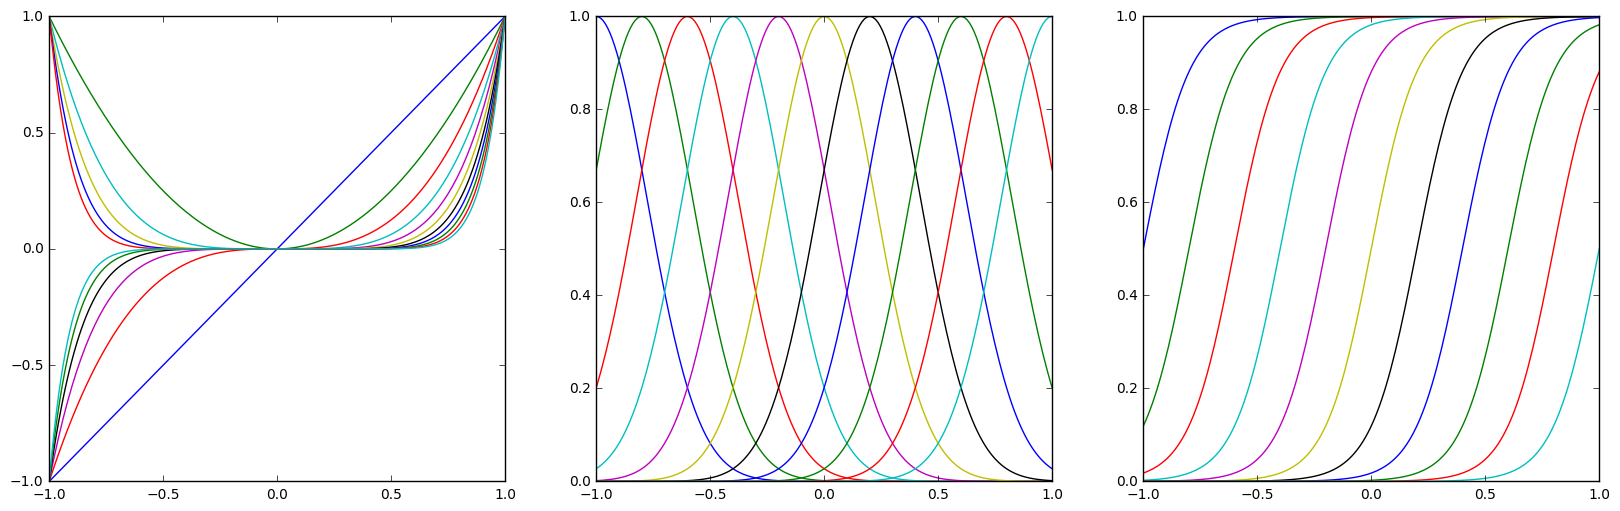

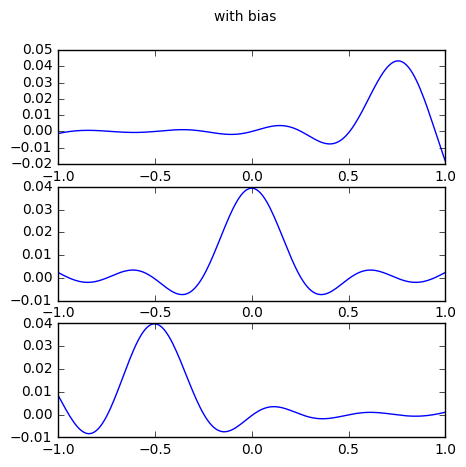

[ 1.00126019  0.99968563  0.99944486]


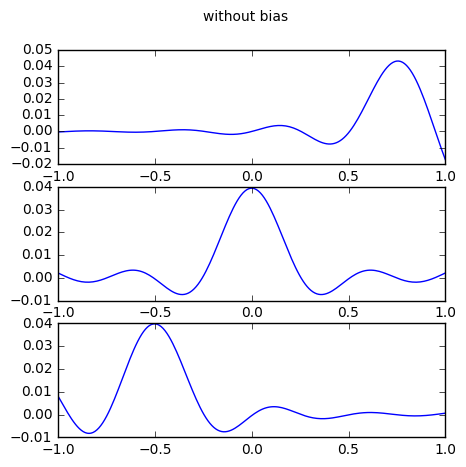

[ 1.00435713  0.99891307  0.99808061]


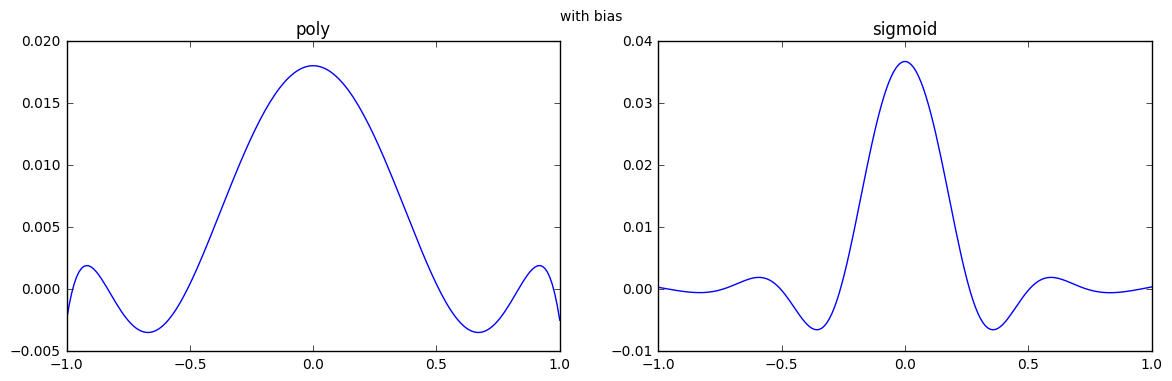

[ 0.99855662  0.99985532  0.99985532  0.9986352   0.99886009]
[ 0.99986788  1.00023375  0.99999914  1.00000623  1.00005174]


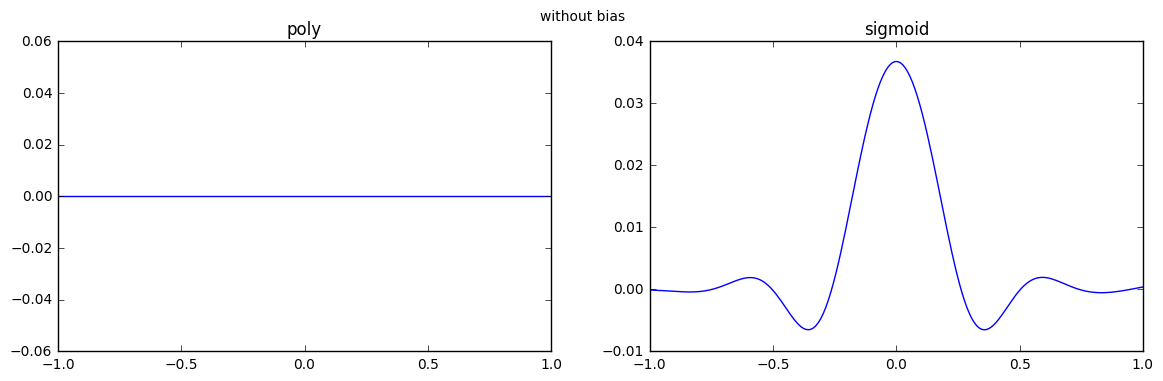

[ 0.          0.89976251  0.89976251  0.05443721  0.21024894]
[ 0.99892286  1.00190571  0.99999297  1.00005075  1.00042179]


In [2]:
everything_equivalent_kernels(11)

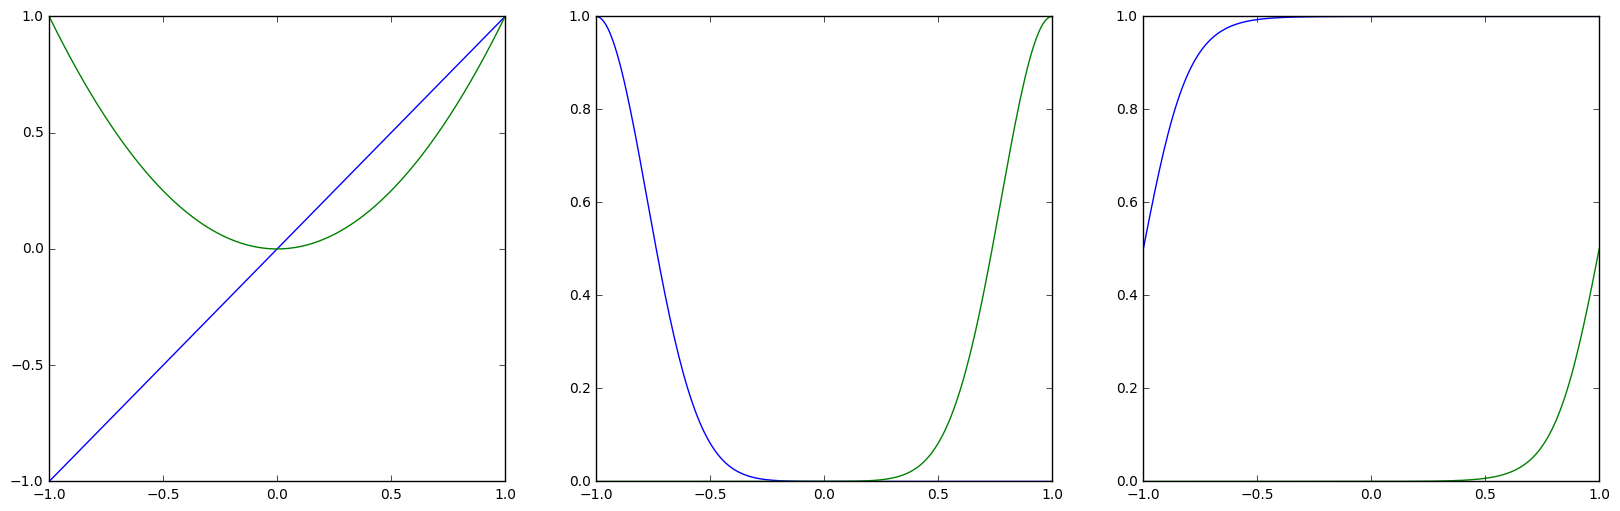

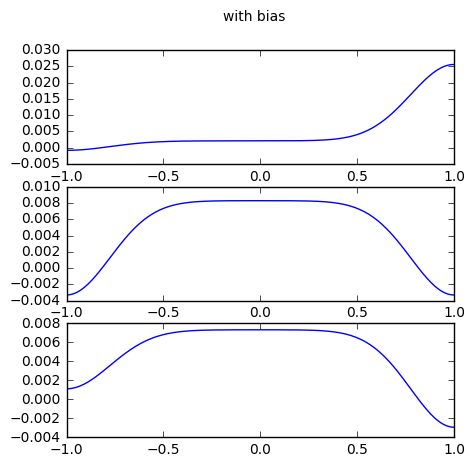

[ 0.99983331  0.99933724  0.99941324]


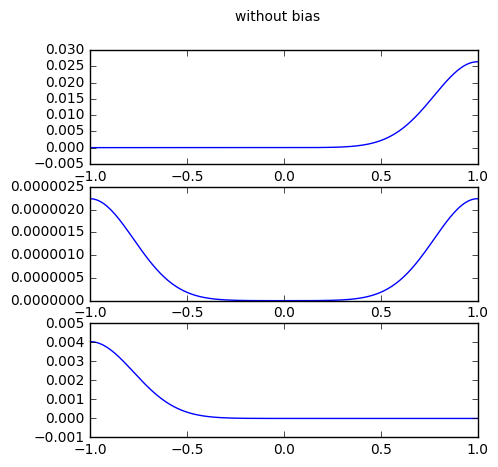

[  7.48528902e-01   1.26977801e-04   1.14790625e-01]


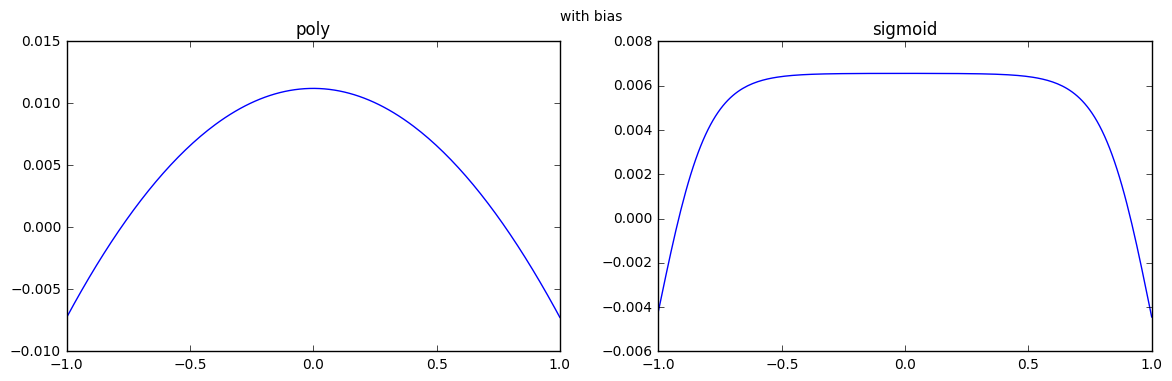

[ 0.99910296  1.00029961  1.00029961  0.99911774  0.99916206]
[ 1.00119084  0.99040273  1.00011558  1.00119168  1.00119126]


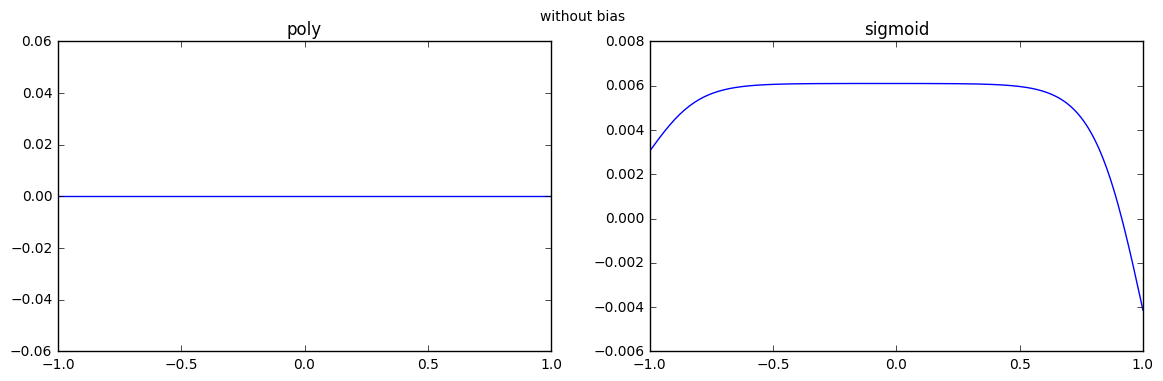

[ 0.          1.33399647  1.33399647  0.01646909  0.06587637]
[ 1.030591    0.75346001  1.002969    1.03061255  1.03060162]


In [3]:
everything_equivalent_kernels(2)
# you can see, when no bias term is added, sum of kernel is NOT necessarily 1, as implied by Eq. (3.64) of PRML.
# I use 2 dim feature instead of 11 here because in this case even Gaussian basis functions doesn't sum to 1.

#### pp. 160

> Instead of introducing a set of basis functions, which implicitly determines an equivalent kernel, we can instead define a localized kernel directly and use this to make predictions for new input vectors x, given the observed training set. This leads to a practical framework for regression (and classification) called Gaussian processes

From this point of view, GP is simple. Just a nonparametric regression model.

## 3.4 Bayesian Model Comparison

### pp. 162

> The model evidence is sometimes also called the marginal likelihood because it can be viewed as a likelihood function over the space of models, in which the parameters have been marginalized out.

> It is also interesting to note that the evidence is precisely the normalizing term that appears in the denominator in Bayes’ theorem when evaluating the posterior distribution over parameters

### pp. 163

> Thus, if parameters are finely tuned to the data in the posterior distribution, then the penalty term is large.

So to increase score, the prior and posterior should match as much as possible.

> the first term will typically **increase**, because a more complex model is better able to fit the data, whereas the second term will **decrease** due to the dependence on $M$.

bold part is the errata.

### pp. 164

> we see that the particular data set $D_0$ can have the highest value of the evidence for the model of intermediate complexity. Essentially, the simpler model cannot fit the data well, whereas the more complex model spreads its predictive probability over too broad a range of data sets and so assigns relatively small probability to any one of them.

While it's intuitive, I don't know how you can know whether your actual data set is of correct size, of intermediate complexity. 

> Implicit in the Bayesian model comparison framework is the assumption that the true distribution from which the data are generated is contained within the set of models under consideration.

This is too hard to satisfy. It requires that the actual data generation distribution is exactly the same as that of the model.

> Thus on average the Bayes factor will always favour the correct model.

The derivation is correct, but the assumption is too strict.

### pp. 165

> a Bayesian approach, like any approach to pattern recognition, needs to make as- sumptions about the form of the model, and if these are invalid then the results can be misleading.

It's also noticed by the author.

> In a practical application, therefore, it will be wise to keep aside an independent test set of data on which to evaluate the overall performance of the final system.

Essentially, all the model selection stuff is BS in practice.

## 3.5 The Evidence Approximation

#### pp. 165

> Here we discuss an approximation in which we set the hyperparameters to specific values determined by maximizing the marginal likelihood function obtained by first integrating over the parameters $w$.

This recaps the method. Compute MAP solution for hyperparameters.

#### pp. 166

> Laplace approximation discussed (Section 4.4) which is based on a local Gaussian approximation centred on the mode of the posterior distribution, might provide a practical alternative to the evidence framework (Buntine and Weigend, 1991). However, the integrand as a function of $w$ typically has a strongly skewed mode so that the Laplace approximation fails to capture the bulk of the probability mass, leading to poorer results than those obtained by maximizing the evidence.

This says that Laplace approximation may not work well.

### 3.5.1 Evaluation of the evidence function

#### pp. 167 

> Here we have assumed a prior of the form (1.65) with the parameter $\alpha$ fixed ... 

so Fig 3.14 actually has no free parameters, $\alpha$ or $\beta$.

### 3.5.2 Maximizing the evidence function

#### pp. 168

> here $\lambda$ is eigenvalue of $\beta$ times (roughly) covariance matrix, not cov matrix itself. That is why in the later analysis, you don't see $\beta$.

#### pp. 169

This is just a fixed point iteration procedure, not guaranteed to converge. Maybe using EM will make the convergence argument easier.

### 3.5.3 Effective number of parameters

Here it's talking about the MAP solution of $w$ as a function of $\alpha$, with prior of form Eq. (1.65). Check Eq. (3.81) and Eq. (3.84) to see why we end up considering $\gamma$ in the MAP solution of $w$.

#### pp. 170, Figure 3.15

here I think $\alpha=0$ means $\alpha \rightarrow 0$, basically flat prior.

For that "nonzero" $\alpha$, I'm not sure exact value, but it shouldn't matter here. Maybe the optimal one giving highest evidence?

#### pp. 170

> The quantity $\gamma$ defined by (3.91) therefore measures the effective total number of well determined parameters.

#### pp. 171

> We shall see in Section 10.1.3 that this result can be obtained from a Bayesian treatment in which we marginalize over the unknown mean.

remove this, according to errata. check pp. 5 of first edition's errata. in generally bayesian approach doesn't guarantee unbias.

> The effective number of parameters that are determined by the data is $\gamma$, with the remaining $M-\gamma$ parameters set to small values by the prior. This is reflected in the Bayesian result for the variance that has a factor  $N-\gamma$ in the denominator, thereby correcting for the bias of the maximum likelihood result

Again I think this is not necessarily a property of Bayesian approaches.

#### pp. 172, Figure 3.16

> It is the intersection of these two curves that defines the optimum value for $\alpha$ given by the evidence procedure

why intersection: check Eq. (3.92). 